In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Online Retail Cleaned.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [2]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

In [3]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalRevenue': 'sum'                                       # Monetary
}).reset_index()


In [4]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [5]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])


In [6]:
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])


In [7]:
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [8]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + \
                   rfm['F_Score'].astype(str) + \
                   rfm['M_Score'].astype(str)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [10]:
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)


In [11]:
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)


In [12]:
def rfm_segment(row):
    if row['R_Score'] == 5 and row['F_Score'] == 5 and row['M_Score'] == 5:
        return 'High-Value Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4:
        return 'Potential Loyalists'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At-Risk Customers'
    else:
        return 'Lost Customers'


In [13]:
rfm['Customer_Segment'] = rfm.apply(rfm_segment, axis=1)


In [14]:
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Customer_Segment']].head()


,CustomerID,Recency,Frequency,Monetary,Customer_Segment
0,12346.0,326,1,77183.60,Lost Customers
1,12347.0,2,7,4310.00,High-Value Customers
2,12348.0,75,4,1797.24,At-Risk Customers
3,12349.0,19,1,1757.55,Potential Loyalists
4,12350.0,310,1,334.40,Lost Customers


In [15]:
rfm['Customer_Segment'].value_counts()


Customer_Segment
Lost Customers          1923
Loyal Customers          791
At-Risk Customers        643
Potential Loyalists      633
High-Value Customers     348
Name: count, dtype: int64

In [16]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,12346.0,326,1,77183.60,1,1,5,115,Lost Customers
1,12347.0,2,7,4310.00,5,5,5,555,High-Value Customers
2,12348.0,75,4,1797.24,2,4,4,244,At-Risk Customers
3,12349.0,19,1,1757.55,4,1,4,414,Potential Loyalists
4,12350.0,310,1,334.40,1,1,2,112,Lost Customers


In [17]:
rfm['Customer_Segment'].value_counts()


Customer_Segment
Lost Customers          1923
Loyal Customers          791
At-Risk Customers        643
Potential Loyalists      633
High-Value Customers     348
Name: count, dtype: int64

In [18]:
segment_analysis = rfm.groupby('Customer_Segment').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Customer_Count=('CustomerID', 'count')
).reset_index()

segment_analysis


,Customer_Segment,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Count
0,At-Risk Customers,152.844479,3.404355,1244.994636,643
1,High-Value Customers,5.445402,18.241379,11221.741121,348
2,Lost Customers,144.018721,1.995840,843.730750,1923
3,Loyal Customers,16.772440,6.355247,2556.963339,791
4,Potential Loyalists,17.431280,1.785150,885.715972,633


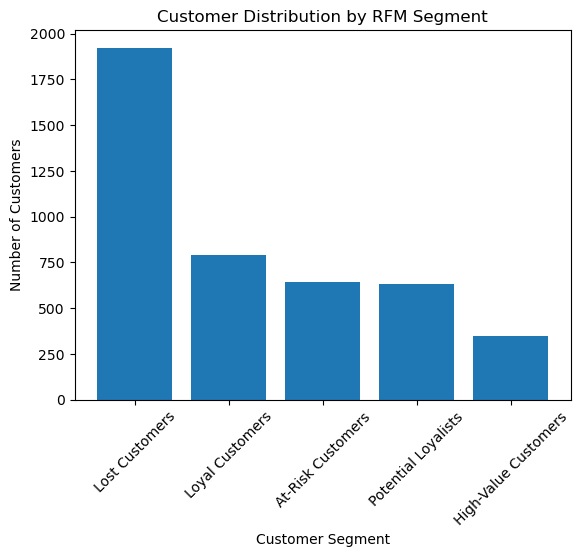

In [19]:
import matplotlib.pyplot as plt

segment_counts = rfm['Customer_Segment'].value_counts()

plt.figure()
plt.bar(segment_counts.index, segment_counts.values)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution by RFM Segment')
plt.xticks(rotation=45)
plt.show()


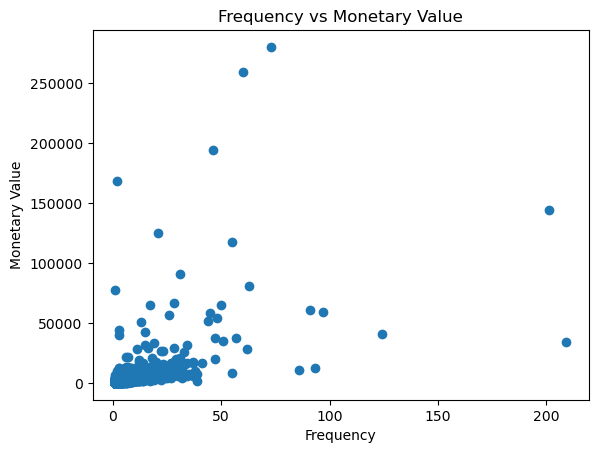

In [20]:
plt.figure()
plt.scatter(rfm['Frequency'], rfm['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.title('Frequency vs Monetary Value')
plt.show()


In [21]:
rfm.to_csv('Customer_RFM_Segmented.csv', index=False)


In [22]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,12346.0,326,1,77183.60,1,1,5,115,Lost Customers
1,12347.0,2,7,4310.00,5,5,5,555,High-Value Customers
2,12348.0,75,4,1797.24,2,4,4,244,At-Risk Customers
3,12349.0,19,1,1757.55,4,1,4,414,Potential Loyalists
4,12350.0,310,1,334.40,1,1,2,112,Lost Customers


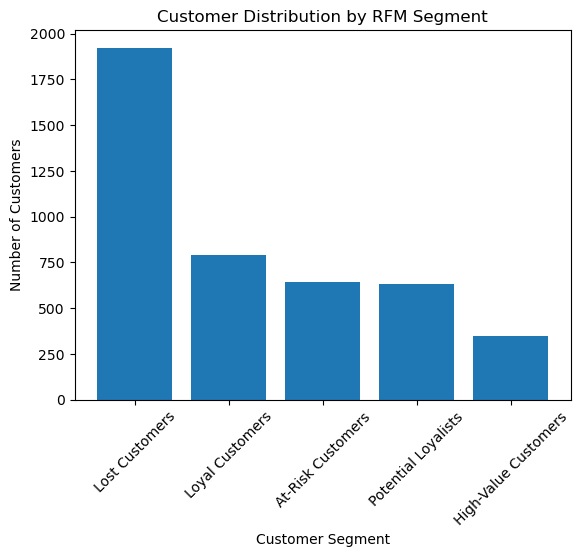

In [23]:
import matplotlib.pyplot as plt

segment_counts = rfm['Customer_Segment'].value_counts()

plt.figure()
plt.bar(segment_counts.index, segment_counts.values)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution by RFM Segment')
plt.xticks(rotation=45)
plt.show()


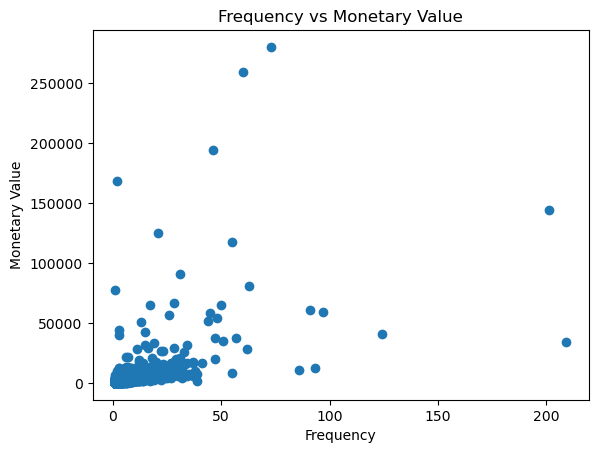

In [24]:
plt.figure()
plt.scatter(rfm['Frequency'], rfm['Monetary'])
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.title('Frequency vs Monetary Value')
plt.show()


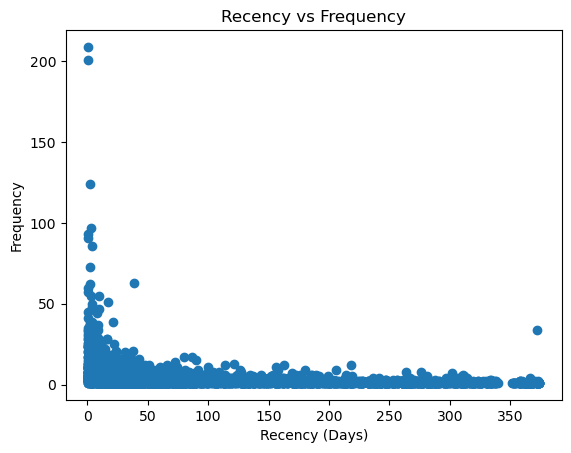

In [25]:
plt.figure()
plt.scatter(rfm['Recency'], rfm['Frequency'])
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency')
plt.show()


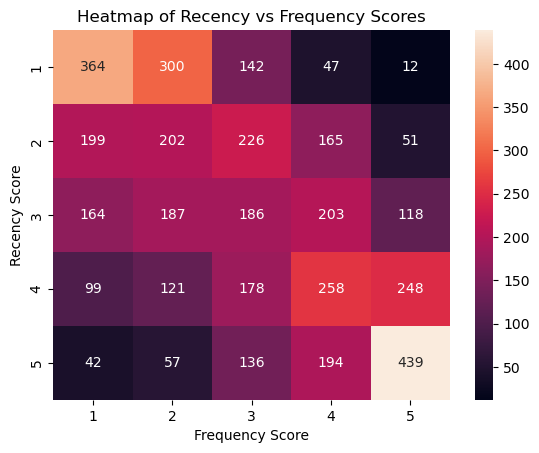

In [26]:
import seaborn as sns

rfm_heatmap = rfm.groupby(['R_Score', 'F_Score']).size().unstack(fill_value=0)

plt.figure()
sns.heatmap(rfm_heatmap, annot=True, fmt='d')
plt.title('Heatmap of Recency vs Frequency Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()


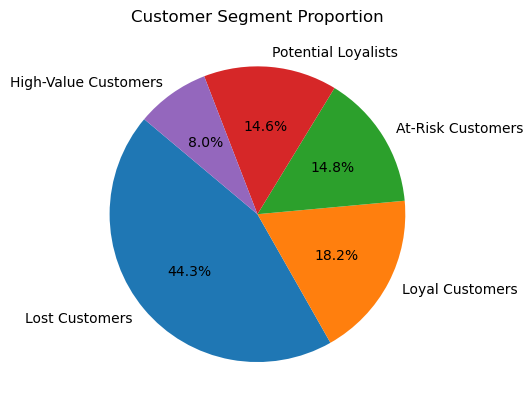

In [27]:
plt.figure()
plt.pie(segment_counts.values,
        labels=segment_counts.index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Customer Segment Proportion')
plt.show()
